In [80]:
import json
import numpy as np
import os
import math
import librosa
from sklearn.model_selection import train_test_split
from Praat import Praat_IdeaLogic as PLogic
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import librosa.display
import glob
import pandas as pd
import joblib
from pydub import AudioSegment;
import pydub;

In [76]:
# audio_file = "all_actors/03-01-01-01-01-01-01.wav"
# X, sample_rate = librosa.load(audio_file,  res_type='kaiser_fast')
# mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T

In [82]:
def extract(audio_file):
    name=os.path.basename(audio_file)
    name=os.path.splitext(name)[0]
    label = int(name[7:8]) - 1
    
    return label, audio_file
    
    
def get_mfcc_2D_with_audio_padding(path, duration_s = 7, sample_rate = 22050, show=False):
    # pad
    audio = pydub.AudioSegment.silent(duration=(duration_s*1000))    # The length you want in ms 
    audio = audio.overlay(pydub.AudioSegment.from_wav(path).set_frame_rate(22050))
    raw = audio.split_to_mono()[0].get_array_of_samples() 
    raw_np = np.array(raw).astype('float64')
    
    # get mfcc
    mfccs = librosa.feature.mfcc(y=raw_np, sr=sample_rate, n_mfcc=40)
    
    if show:
        plt.figure(figsize=(17.5, 5))
        librosa.display.specshow(mfccs, 
                                 x_axis="time", 
                                 sr=sample_rate)
        plt.colorbar(format="%+2.f")
        plt.show()
    return mfccs.T

    
def get_mfcc_2D_segmentation(audio_file, num_mfcc=40, n_fft=2048, hop_length=512, num_segments=5):
    SAMPLE_RATE = 22050
    TRACK_DURATION = 0.5 # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            return True, mfcc
        
    return False, mfcc


def return_feats(dir_name):
    X = []
    y = []
    err_cnt = 0
    err_list = []
    exeption_list = []
    
    #progression bar 
    file_count = len(dir_name)
    bar = tqdm(desc="generating 2D mfccs", total=file_count)
    tot = 0
    
    for file in dir_name:
        bar.update(1)
        tot += 1
        label, audio_file = extract(file)
        try:
            X.append(get_mfcc_2D_with_audio_padding(audio_file))
            y.append(label)
            
        except Exception as e:
            
            err_cnt += 1
            err_list.append(audio_file)
            exeption_list.append(str(e))
            print("{}.error at:".format(err_cnt), audio_file)
            
        
    return X, y, err_cnt, err_list, exeption_list

In [84]:
dir_name = glob.glob("toronto_ds/conc_data/*.wav")
X, y, err_cnt, err_list, exeption_list = return_feats(dir_name)

/opt/conda/lib/python3.7/site-packages/pydub/utils.py:193: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


1.error at: toronto_ds/conc_data/47-78-05-85-45-58-80.wav


/opt/conda/lib/python3.7/site-packages/pydub/utils.py:193: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


2.error at: toronto_ds/conc_data/45-19-06-13-72-83-26.wav


In [92]:
print("exeption list: ", np.unique(np.array(exeption_list)))
print("error at: ",err_list)
print("error count: ",err_cnt)

exeption list:  ["[Errno 2] No such file or directory: 'ffprobe': 'ffprobe'"]
error at:  ['toronto_ds/conc_data/47-78-05-85-45-58-80.wav', 'toronto_ds/conc_data/45-19-06-13-72-83-26.wav']
error count:  2


In [95]:
X_name, y_name = '2D mfccs padding/X.joblib', '2D mfccs padding/y.joblib'
X, y = np.asarray(X), np.asarray(y)
y = np.asarray(y)
joblib.dump(X, X_name)
joblib.dump(y, y_name)

['2D mfccs padding/y.joblib']

# mesuring audio durations 

In [94]:
# def extract(audio_file):
#     name=os.path.basename(audio_file)
#     name=os.path.splitext(name)[0]
#     label = int(name[3:5])
    
#     return label, audio_file

# def get_length(audio_file):
#     y, sr = librosa.load(audio_file)
#     return librosa.get_duration(y=y, sr=sr)

# def get_all_lengths(dir_name):
#     lengths = []

#     #progression bar 
#     file_count = len(dir_name)
#     bar = tqdm(desc="proccessing files", total=file_count)
#     tot = 0
    
#     for file in dir_name:
#         bar.update(1)
#         tot += 1
#         label, audio_file = extract(file)
#         length = get_length(audio_file)
#         lengths.append( [int(length), length,label, audio_file])
        
#     return lengths

In [93]:
#l = get_all_lengths(dir_name)
l_ = l.copy()

In [23]:
df = pd.DataFrame(np.array(l_), columns = ['int cast','true length','label', "audio file"])
df.head()

,int cast,true length,label,audio file
0,2,2.181360544217687,9,toronto_ds/conc_data/95-79-03-46-66-41-83.wav
1,1,1.3265759637188208,5,toronto_ds/conc_data/91-75-05-92-90-85-19.wav
2,3,3.570294784580499,1,toronto_ds/conc_data/03-01-03-02-02-01-20.wav
3,1,1.5886167800453515,6,toronto_ds/conc_data/85-26-06-27-51-61-31.wav
4,3,3.53687074829932,1,toronto_ds/conc_data/03-01-03-01-01-01-06.wav


In [24]:
df["int cast"].unique()

array(['2', '1', '3', '4', '5', '6'], dtype=object)

<AxesSubplot:>

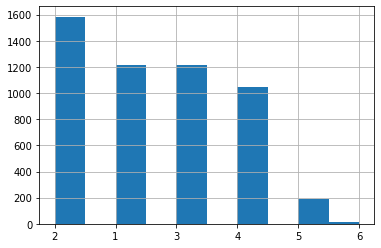

In [25]:
df["int cast"].hist()

In [26]:
df.to_csv("major-set_duration")

In [63]:
# df.loc[df["int cast"]==5]
df.loc[df['int cast'] == '4']

,int cast,true length,label,audio file
5,4,4.337687074829932,2,toronto_ds/conc_data/03-02-01-01-02-01-13.wav
10,4,4.50453514739229,2,toronto_ds/conc_data/03-02-06-02-01-01-02.wav
17,4,4.93827664399093,2,toronto_ds/conc_data/03-02-06-01-01-01-17.wav
24,4,4.471156462585034,1,toronto_ds/conc_data/03-01-07-02-01-02-18.wav
27,4,4.571292517006802,2,toronto_ds/conc_data/03-02-05-02-02-01-03.wav
...,...,...,...,...
5212,4,4.1374603174603175,1,toronto_ds/conc_data/03-01-03-02-01-02-12.wav
5217,4,4.037369614512472,1,toronto_ds/conc_data/03-01-05-01-02-02-22.wav
5229,4,4.070748299319728,2,toronto_ds/conc_data/03-02-05-02-01-02-04.wav
5232,4,4.404399092970522,2,toronto_ds/conc_data/03-02-03-02-02-02-02.wav


In [56]:
df["true length"].max()
df["true length"].min()

'1.2541043083900227'